# Importando datos y librerias.

In [1]:
import pandas as pd
import seaborn as sns
import ipywidgets as widgets
import numpy as np
from ipywidgets import interact, interact_manual
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf  
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import scipy.stats as scs
from itertools import product  
from tqdm import tqdm_notebook
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed 
import tensorflow as tf
tf.random.set_seed(1)
from sklearn.preprocessing import MinMaxScaler
import math
import xgboost as xg
import json

In [2]:
data=pd.read_csv('MDT_data_tesis_new.csv',sep='|')

In [3]:
data.head()

,Unnamed: 0,nemotecnico,fecha,cantidad,volumen,precio_cierre,precio_mayor,precio_medio,precio_menor,variacion%,variacion_log
0,0,BCOLOMBIA,2019-10-02,284830.0,1.126933e+10,39500.0,39980.0,39565.11,39500.0,-1.25,-0.012579
1,1,BCOLOMBIA,2019-10-03,140793.0,5.645285e+09,40160.0,40200.0,40096.35,39060.0,1.67,0.016571
2,2,BCOLOMBIA,2019-10-04,24249.0,9.755599e+08,40300.0,40300.0,40230.93,39880.0,0.35,0.003480
3,3,BCOLOMBIA,2019-10-07,573422.0,2.294618e+10,40360.0,40400.0,40016.22,40000.0,0.15,0.001488
4,4,BCOLOMBIA,2019-10-08,97905.0,3.917192e+09,40200.0,40200.0,40010.14,39540.0,-0.40,-0.003972


In [4]:
data.dtypes

Unnamed: 0         int64
nemotecnico       object
fecha             object
cantidad         float64
volumen          float64
precio_cierre    float64
precio_mayor     float64
precio_medio     float64
precio_menor     float64
variacion%       float64
variacion_log    float64
dtype: object

#### Se procede a hacer un ajuste en los tipos de datos y a crear variables de interes para realizar los respectivos análisis.

In [5]:
data['fecha']= pd.to_datetime(data['fecha'])
data['dia_semana']=data['fecha'].dt.day_name()

In [6]:
data.dtypes

Unnamed: 0                int64
nemotecnico              object
fecha            datetime64[ns]
cantidad                float64
volumen                 float64
precio_cierre           float64
precio_mayor            float64
precio_medio            float64
precio_menor            float64
variacion%              float64
variacion_log           float64
dia_semana               object
dtype: object

In [7]:
data.head()

,Unnamed: 0,nemotecnico,fecha,cantidad,volumen,precio_cierre,precio_mayor,precio_medio,precio_menor,variacion%,variacion_log,dia_semana
0,0,BCOLOMBIA,2019-10-02,284830.0,1.126933e+10,39500.0,39980.0,39565.11,39500.0,-1.25,-0.012579,Wednesday
1,1,BCOLOMBIA,2019-10-03,140793.0,5.645285e+09,40160.0,40200.0,40096.35,39060.0,1.67,0.016571,Thursday
2,2,BCOLOMBIA,2019-10-04,24249.0,9.755599e+08,40300.0,40300.0,40230.93,39880.0,0.35,0.003480,Friday
3,3,BCOLOMBIA,2019-10-07,573422.0,2.294618e+10,40360.0,40400.0,40016.22,40000.0,0.15,0.001488,Monday
4,4,BCOLOMBIA,2019-10-08,97905.0,3.917192e+09,40200.0,40200.0,40010.14,39540.0,-0.40,-0.003972,Tuesday


# 1. Exploración de datos.

En este paso se va a vericar los valores que se tienen en los datos y si por diferentes agrupaciones de interes se tienen missing values.

## Missing values de forma general 

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15393 entries, 0 to 15392
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Unnamed: 0     15393 non-null  int64         
 1   nemotecnico    15393 non-null  object        
 2   fecha          15393 non-null  datetime64[ns]
 3   cantidad       15393 non-null  float64       
 4   volumen        15393 non-null  float64       
 5   precio_cierre  15393 non-null  float64       
 6   precio_mayor   15393 non-null  float64       
 7   precio_medio   15393 non-null  float64       
 8   precio_menor   15393 non-null  float64       
 9   variacion%     15393 non-null  float64       
 10  variacion_log  15393 non-null  float64       
 11  dia_semana     15393 non-null  object        
dtypes: datetime64[ns](1), float64(8), int64(1), object(2)
memory usage: 1.4+ MB


#### La información de manera general no tiene valores null en ninguno de sus campos. Se debe verificar para diferentes agrupaciónes de la información.

# Analisis de series de tiempo

In [9]:
data_series = data.copy()

In [10]:
data_series['nemotecnico'].value_counts()

BCOLOMBIA     733
GRUPOAVAL     733
PFGRUPOARG    733
PFDAVVNDA     733
PFCORFICOL    733
PFCEMARGOS    733
PFAVAL        733
NUTRESA       733
ISA           733
GRUPOSURA     733
GRUPOARGOS    733
BOGOTA        733
EXITO         733
ECOPETROL     733
CORFICOLCF    733
CNEC          733
CLH           733
CEMARGOS      733
CELSIA        733
BVC           733
PFGRUPSURA    733
Name: nemotecnico, dtype: int64

In [11]:
data_series1=data_series[data_series['nemotecnico']=='BCOLOMBIA']

In [12]:
def plotPromedioMovil(series, window, plot_intervals=False, scale=1.96, 
                      plot_anomalies=False):

    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Media Movil\n Tamaño de la ventana = {}".format(window))
    plt.plot(rolling_mean, "g", label="Tendencia Media Móvil")

    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Límite Superior / Límite Inferior")
        plt.plot(lower_bond, "r--")
        
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Valores Actuales")
    plt.legend(loc="upper left")
    plt.grid(True)

In [13]:
def tsplot(y, lags=None, figsize=(13, 5), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [14]:
def tsplot_(y, lags=None, figsize=(13, 5), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Tunning Serie de Tiempo\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [15]:
data_series.head()

,Unnamed: 0,nemotecnico,fecha,cantidad,volumen,precio_cierre,precio_mayor,precio_medio,precio_menor,variacion%,variacion_log,dia_semana
0,0,BCOLOMBIA,2019-10-02,284830.0,1.126933e+10,39500.0,39980.0,39565.11,39500.0,-1.25,-0.012579,Wednesday
1,1,BCOLOMBIA,2019-10-03,140793.0,5.645285e+09,40160.0,40200.0,40096.35,39060.0,1.67,0.016571,Thursday
2,2,BCOLOMBIA,2019-10-04,24249.0,9.755599e+08,40300.0,40300.0,40230.93,39880.0,0.35,0.003480,Friday
3,3,BCOLOMBIA,2019-10-07,573422.0,2.294618e+10,40360.0,40400.0,40016.22,40000.0,0.15,0.001488,Monday
4,4,BCOLOMBIA,2019-10-08,97905.0,3.917192e+09,40200.0,40200.0,40010.14,39540.0,-0.40,-0.003972,Tuesday


In [16]:
@interact
def series_analisis(Accion=data_series['nemotecnico'].unique(),window=(1, 90, 1)):
    info = data_series[(data_series['nemotecnico']==Accion)]
    tabla = info[['fecha','nemotecnico','variacion_log']]
    pivot_table = tabla.copy()
    pivot_table.set_index('fecha',inplace=True)
    idx = pd.date_range(pivot_table.index.min(), pivot_table.index.max())
    pivot_table=pivot_table.reindex(idx, fill_value=0)
    pivot_table.reset_index(inplace=True)
    pivot_table.rename(columns={'index':'fecha'},inplace=True)
    pivot_table.drop(columns=['nemotecnico'],inplace=True)
    pivot_table.set_index('fecha',inplace=True)
    X = pivot_table['variacion_log'].values
    result = sm.tsa.stattools.adfuller(X)
    if result[1]<0.05: 
        rta='Rechazo H0. La serie de tiempo No tiene una raíz unitaria, entonces es estacionaria'
    else:
        rta='No Rechazo Ho. La serie de tiempo tiene una raíz unitaria, entonces no es estacionaria'
    print('')
    print('Prueba de Dickey-Fuller test')
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print(rta)
    descomposicion = sm.tsa.seasonal_decompose(pivot_table['variacion_log'],model='additive')  
 
    return plotPromedioMovil(pivot_table,window,plot_intervals=True, plot_anomalies=True),tsplot(pivot_table['variacion_log'], lags=59),descomposicion.plot()


interactive(children=(Dropdown(description='Accion', options=('BCOLOMBIA', 'BOGOTA', 'BVC', 'CELSIA', 'CEMARGO…

## Se genera una función de tunning que permita eliminar los diferentes componentes a través de diferencia de desfases.

In [17]:
@interact
def series_tunning(Accion=data_series['nemotecnico'].unique(),PeriodoEstacional=(1, 90, 1)): #30
    info = data_series[(data_series['nemotecnico']==Accion)]
    tabla = info[['fecha','nemotecnico','variacion_log']]
    pivot_table = tabla.copy()
    pivot_table.set_index('fecha',inplace=True)
    idx = pd.date_range(pivot_table.index.min(), pivot_table.index.max())
    pivot_table=pivot_table.reindex(idx, fill_value=0)
    pivot_table.reset_index(inplace=True)
    pivot_table.rename(columns={'index':'fecha'},inplace=True)
    pivot_table.drop(columns=['nemotecnico'],inplace=True)
    pivot_table.set_index('fecha',inplace=True)
    serie_diff = pivot_table['variacion_log'] - pivot_table['variacion_log'].shift(PeriodoEstacional)
    return tsplot_(serie_diff[PeriodoEstacional:], lags=50)


interactive(children=(Dropdown(description='Accion', options=('BCOLOMBIA', 'BOGOTA', 'BVC', 'CELSIA', 'CEMARGO…

#### Se debe generar un proceso iterativo para elegir de manera automatica los mejores modelos ya que elegir los componentes manualmente toma bastante tiempo. Para elegir entre un modelo ARIMA o SARIMA, se tomará como referencia la prueba de Dickey-Fuller.

# 4. Construcción de Modelos.

En la construcción de los modelos se realiza una partición de 80 % de datos para training y 20 % para test, con el fín del validar la precisión del modelo.

# Construcción de modelos con series clasicas ARIMA y SARIMA

En este paso se construiran modelos clasicos de series temporales. 

In [18]:
from sklearn.metrics import mean_absolute_error

In [19]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

def mae(y_true, y_pred):
    return np.mean(np.abs((np.asarray(y_pred) - np.asarray(y_true))/ np.asarray(y_true)))

def rmse(targets, predictions):
    differences = np.asarray(predictions) - np.asarray(targets)                       
    differences_squared = differences ** 2                    
    mean_of_differences_squared = differences_squared.mean()  
    rmse_val = np.sqrt(mean_of_differences_squared)          
    return rmse_val    

In [20]:
def optimizerMODEL(serie,parameters_list, d, D, s,model,dias_predecir):
    
    results = []
    best_error = float("inf")

    for param in tqdm_notebook(parameters_list):
        try:
            if model == 1:
                model=sm.tsa.statespace.SARIMAX(serie, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
              
            else:
                model=ARIMA(serie, order=(param[0], d, param[1])).fit(disp=0)          
        except:
            continue
        
        data = serie.copy()
        data.columns = ['actual']
        data['model'] = model.fittedvalues
        data['model'][:s+d] = np.NaN
        forecast = model.predict(start = data.shape[0], end = data.shape[0]+dias_predecir)
        forecast = data.model.append(forecast)
        #error = mean_absolute_percentage_error(data['actual'][s+d:], data['model'][s+d:])
        #error = (abs(data['model'][s+d:]-data['actual'][s+d:])/data['actual'][s+d:]).mean()
        error = mean_absolute_error(data['actual'][s+d:], data['model'][s+d:])
        if error < best_error:
            best_model = model
            best_error = error
            best_param = param
        results.append([param, error])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'error']
    result_table = result_table.sort_values(by='error', ascending=True).reset_index(drop=True)
    
    return result_table

In [21]:
def plotSARIMA(series, model, n_steps,s,d,modelo):
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    
    # Pronostico de n periodos de tiempo
    if modelo==1:
        data['sarima_model'] = model.fittedvalues
        data['sarima_model'][:s+d] = np.NaN
        forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
        forecast = data.sarima_model.append(forecast)
    else:
        data['sarima_model'] = model.fittedvalues
        data['sarima_model'][:s+d] = np.NaN
        forecast = model.forecast()
        forecast = data.sarima_model.append(forecast[0][0])
    # Calculando error.
    #error = mean_absolute_percentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])
    error = mean_absolute_error(data['actual'][s+d:], data['sarima_model'][s+d:])
    plt.figure(figsize=(15, 7))
    #plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.title("Mean Absolute Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

In [22]:
@interact_manual
#def training_model(Arima=False,Sarima=True,Guardar_Result=True,limpiar_result=False,Accion=data_series['nemotecnico'].unique(),ps=(1,15,1),d=(0,2,1),qs=(1,15,1),Ps=(1,15,1) ,D=(0,2,1),Qs=(1,15,1),s=(1,30,1),dias_predecir=(1,90,1),gap_range=(0,15,1)):
def training_model(Arima=False,Sarima=True,Guardar_Result=True,limpiar_result=False,Accion=data_series['nemotecnico'].unique(),ps=(1,15,1),d=1,qs=(1,15,1),Ps=(1,15,1) ,D=1,Qs=(1,15,1),s=7,dias_predecir=(1,90,1),gap_range=(0,15,1)):    
    ps_ = range(1 if ps-gap_range<1 else ps-gap_range, ps) #Ultimo valor significativo PAFC
    d_=abs(d) 
    qs_ = range(1 if qs-gap_range<1 else qs-gap_range, qs) #Ultimo valor significativo AFC
    Ps_ = range(1 if Ps-gap_range<1 else Ps-gap_range, Ps) #Periodos estacionales significativos
    D_=D
    Qs_ = range(1 if Qs-gap_range<1 else Qs-gap_range, Qs)
    s_ = s # estacionalidad
    #creando lista con las combinación de parametros
    parameters = product(ps_, qs_, Ps_, Qs_)
    parameters_list = list(parameters)
    # serie=data_series[(data_series['nemotecnico']==Accion)]
    # serie.rename(columns={'dia_semana':'Cantidad TRX'},inplace=True)
    # idx = pd.date_range(serie.index.min(), serie.index.max())
    # serie=serie.reindex(idx, fill_value=0)
    # serie=serie.reset_index()
    # serie=serie.set_index('index').asfreq('d')
    # serie['Cantidad TRX']=serie['Cantidad TRX'].astype('int')

    
    info = data_series[(data_series['nemotecnico']==Accion)]
    tabla=info.copy()
    serie = tabla[['fecha','nemotecnico','variacion_log']]
    del tabla, info
    #serie=data_series[(data_series['nemotecnico']==Accion)]
    serie.set_index('fecha',inplace=True)
    idx = pd.date_range(serie.index.min(), serie.index.max())
    serie=serie.reindex(idx, fill_value=0)
    serie.reset_index(inplace=True)
    serie.rename(columns={'index':'fecha'},inplace=True)
    serie.drop(columns=['nemotecnico'],inplace=True)
    serie.set_index('fecha',inplace=True)
    
    if Arima==True:
        modelo='ARIMA'
        mod=0
        result_table = optimizerMODEL(serie,parameters_list, d_, D, s_,0,dias_predecir)
        p, q, P, Q = result_table.parameters[0]
        best_model = ARIMA(serie['variacion_log'], order=(p,d,q)).fit(disp=0)
    else:
        modelo = 'SARIMA'
        mod=1
        result_table = optimizerMODEL(serie,parameters_list, d_, D, s_,1,dias_predecir)
        p, q, P, Q = result_table.parameters[0]
        best_model=sm.tsa.statespace.SARIMAX(serie['variacion_log'], order=(p, d_, q), 
                                              seasonal_order=(P, D, Q, s_)).fit(disp=-1)

    if Guardar_Result == True:    
        dict_resul={'Serie':str(Accion),'Modelo':modelo,'MAE':result_table['error'][0]}
        if limpiar_result == False:
            with open('C:/Users/USUARIO/Desktop/resultados_v1.json', 'a') as file:
                file.write(json.dumps(dict_resul, ensure_ascii=False))
                file.write("\n")
                file.close()
        else:
            with open('C:/Users/USUARIO/Desktop/resultados_v1.json', 'w') as file:
                file.write(json.dumps(dict_resul, ensure_ascii=False))
                file.write("\n")
                file.close()


    return best_model.summary(),tsplot_(best_model.resid[dias_predecir+1:], lags=50),plotSARIMA(serie, best_model, dias_predecir,s_,d_,mod)

interactive(children=(Checkbox(value=False, description='Arima'), Checkbox(value=True, description='Sarima'), …

# Entrenando una red neuronal monocapa

Se construye una red nueronal monocapa con conexión densa y se entrenan con los hiperparametros por defecto para ver el comportamiento. La construcción de esta red se hace como si fuera un modelo supervisado, donde la y esta determinada por y-t periodos anteriores. Por ejemplo se puede crear un modelo supervisado donde el valor de dia 7 esta determinado por los 6 días anteriores, o el día 15 esta determinado por los 14 días anteriores. Esta ventana de tiempo es movil.

El número de neuronas asignadas esta en función de las variables. Se agrega un call de parada temprana, donde se monitorea la función de perdida del conjunto de validación, con el fin de evitar overfitting en el entrenamiento. Como valor de selección del mejor modelo se utilizará el MAPE.

In [23]:
for i in range(0, 1):
    print(i)

0


In [24]:
#Función para construir la matriz del modelo supervisado
def serie_supervisada(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('y%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('y%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('y%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [25]:
#Función para construir la matriz del modelo supervisado
def serie_supervisada(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('y%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('y%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('y%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [26]:
# Función de predicción
def agregarNuevoValor(x_test,newVal):
    arr=[]
    for i in x_test[0][0][1:x_test.shape[2]]:
        arr.append(i)
    arr.append(newVal[0][0])
    arr=pd.DataFrame(arr).values
    arr=np.array([arr])
    arr=arr.reshape((arr.shape[0], 1, arr.shape[1]))
    x_test=arr
    return x_test

In [27]:
def rmse_rn(targets, predictions):
    differences = predictions - targets                     
    differences_squared = differences ** 2                    
    mean_of_differences_squared = differences_squared.mean()  
    rmse_val = np.sqrt(mean_of_differences_squared)          
    return rmse_val

In [28]:
@interact_manual
def construccion_RN(Guardar_Result=True,limpiar_result=False,Accion=data_series['nemotecnico'].unique(),Input_features=(1,90,1),batch_size=(1,30,1),dias_predecir=(1,90,1)):
    # serie=data_series[(data_series['nemotecnico']==Accion)].groupby('YYMMDD').agg({'dia_semana':'count'})
    # serie.rename(columns={'dia_semana':'Cantidad TRX'},inplace=True)
    # idx = pd.date_range(serie.index.min(), serie.index.max())
    # idx_ = pd.date_range(data_series['YYMMDD'].min(), data_series['YYMMDD'].max()+np.timedelta64(dias_predecir,'D'))
    # serie=serie.reindex(idx, fill_value=0)
    # serie=serie.reset_index()
    # serie=serie.set_index('index').asfreq('d')
    # serie['Cantidad TRX']=serie['Cantidad TRX'].astype('float32')
    


    info = data_series[(data_series['nemotecnico']==Accion)]
    tabla=info.copy()
    serie = tabla[['fecha','nemotecnico','variacion_log']]
    del tabla, info
    #serie=data_series[(data_series['nemotecnico']==Accion)]
    serie.set_index('fecha',inplace=True)
    idx = pd.date_range(serie.index.min(), serie.index.max())
    idx_ = pd.date_range(serie.index.min(), serie.index.max()  + np.timedelta64(dias_predecir,'D'))
    serie=serie.reindex(idx, fill_value=0)
    serie.reset_index(inplace=True)
    serie.rename(columns={'index':'fecha'},inplace=True)
    serie.drop(columns=['nemotecnico'],inplace=True)
    serie.set_index('fecha',inplace=True)


    values = serie['variacion_log'].values
    values = values.astype('float32')
    scaler = MinMaxScaler(feature_range=(-1, 1))
    values=values.reshape(-1, 1) 
    scaled = scaler.fit_transform(values)
    reframed = serie_supervisada(scaled, Input_features, 1)  
    train_size=len(reframed)*0.8
    values = reframed.values
    train,test  = values[:int(train_size), :],values[int(train_size):, :]
    x_train, y_train = train[:, :-1], train[:, -1]
    x_test, y_test = test[:, :-1], test[:, -1]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
    tf.keras.optimizers.Adam(
    learning_rate=0.01, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
    name='Adam'
)
    
    model=Sequential()
    model.add(Dense(Input_features,input_shape=(1,Input_features), activation='linear'))
    model.add(Dense(1, activation='linear'))
    model.compile(loss='mae',optimizer='Adam',metrics=['mse'])
    
    es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=3,mode='min')

    params={'epochs':500,
    'batch_size':15,
    'validation_split':0.1,
    'shuffle':False, 'verbose':0,'seed':1234}
    
    history=model.fit(x_train,y_train,
                     epochs=500,
                     batch_size=batch_size,
                     validation_split=0.1,
                     callbacks=[es],
                     shuffle=False, verbose=0)
    plt.plot(history.history['loss'],label='Training Loss')
    plt.plot(history.history['val_loss'],label='Validation Loss')
    plt.title('Validación Función de Perdida', fontsize=20)
    plt.xlabel('Epochs', fontsize=20)
    plt.ylabel('Loss Value', fontsize=20)
    plt.legend(fontsize=10)
    plt.show()
    testPredict = model.predict(x_test)
    testPredict=[a[0][0] for a in testPredict]
    testPredict = scaler.inverse_transform(np.array(testPredict).reshape(1, -1))
    trainPredict = model.predict(x_train)
    trainPredict=[a[0][0] for a in trainPredict]
    trainPredict = scaler.inverse_transform(np.array(trainPredict).reshape(1, -1))
    y_train = scaler.inverse_transform([y_train])
    y_test = scaler.inverse_transform([y_test])
    serie.reset_index(inplace=True)
    
    predicciones_train=pd.DataFrame(trainPredict[0])
    valores_train=pd.DataFrame(y_train[0])
    predicciones_train.set_index(serie['fecha'].iloc[:x_train.shape[0]],inplace=True)
    valores_train.set_index(serie['fecha'].iloc[:x_train.shape[0]],inplace=True)
    
    predicciones_test=pd.DataFrame(testPredict[0])
    valores_test=pd.DataFrame(y_test[0])
    predicciones_test.set_index(serie['fecha'].iloc[x_train.shape[0]+Input_features:],inplace=True)
    valores_test.set_index(serie['fecha'].iloc[x_train.shape[0]+Input_features:],inplace=True)
    error_mape = mean_absolute_percentage_error(valores_test, predicciones_test)
    print(error_mape)
    error = mean_absolute_error(valores_test, predicciones_test)
    print(error)
    error_rmse = rmse_rn(valores_test, predicciones_test)
    print(error_rmse[0])
    
    results=[]
    incio=x_test[-1:]
    for i in range(dias_predecir):
        parcial=model.predict(incio)
        parcial_=scaler.inverse_transform(parcial[0])
        results.append(parcial_[0][0])
        incio=agregarNuevoValor(incio,parcial[0])
    result=pd.DataFrame(results)[0]

    plt.figure(figsize=(15,5))
    plt.plot(idx.values,serie['variacion_log'],c='b', label='Serie Original')
    plt.plot(idx_[len(x_train)+Input_features:len(serie)].values,testPredict[0],c='r', label='Predicción Test')
    plt.plot(idx_[Input_features:len(x_train)+Input_features].values,trainPredict[0],c='y', label='Predicción Train')
    plt.plot(idx_[len(serie):len(idx_)].values,result,c='m', label='Predicción 90 Dias')
    plt.xticks(rotation=90)
    plt.legend(fontsize=10)
    plt.title('Resultados del Modelo', fontsize=20)
    plt.title("Modelo RNN"+ ' '+"Mean Absolute Error: {0:.2f}%".format(error) + ' '+ "Accion:" + ' '+ str(Accion), fontsize=20)
    plt.xlabel('Días', fontsize=20)
    plt.ylabel('Log Variacion Precio ', fontsize=20)
    plt.show()

    if Guardar_Result == True:    
        dict_resul={'Serie':str(Accion),'Modelo':'Red Neuronal','RMSE':error_rmse[0],'MAE':error,'MAPE':error_mape,'PARAMETROS XGB':params}
        if limpiar_result == False:
            with open('C:/Users/USUARIO/Desktop/resultados_v1.json', 'a') as file:
                file.write(json.dumps(dict_resul, ensure_ascii=False))
                file.write("\n")
                file.close()
        else:
            with open('C:/Users/USUARIO/Desktop/resultados_v1.json', 'w') as file:
                file.write(json.dumps(dict_resul, ensure_ascii=False))
                file.write("\n")
                file.close()

interactive(children=(Checkbox(value=True, description='Guardar_Result'), Checkbox(value=False, description='l…

# Entrenando un modelo de regresión con XGBoots

### Pruebas individuales de Tunning= BCOLOMBIA

In [29]:
from sklearn.model_selection import RandomizedSearchCV

In [123]:
data_series[(data_series['nemotecnico']=='BCOLOMBIA')]

,Unnamed: 0,nemotecnico,fecha,cantidad,volumen,precio_cierre,precio_mayor,precio_medio,precio_menor,variacion%,variacion_log,dia_semana
0,0,BCOLOMBIA,2019-10-02,284830.0,1.126933e+10,39500.0,39980.0,39565.11,39500.0,-1.25,-0.012579,Wednesday
1,1,BCOLOMBIA,2019-10-03,140793.0,5.645285e+09,40160.0,40200.0,40096.35,39060.0,1.67,0.016571,Thursday
2,2,BCOLOMBIA,2019-10-04,24249.0,9.755599e+08,40300.0,40300.0,40230.93,39880.0,0.35,0.003480,Friday
3,3,BCOLOMBIA,2019-10-07,573422.0,2.294618e+10,40360.0,40400.0,40016.22,40000.0,0.15,0.001488,Monday
4,4,BCOLOMBIA,2019-10-08,97905.0,3.917192e+09,40200.0,40200.0,40010.14,39540.0,-0.40,-0.003972,Tuesday
...,...,...,...,...,...,...,...,...,...,...,...,...
728,728,BCOLOMBIA,2022-09-26,53197.0,1.662098e+09,30970.0,33100.0,31244.20,30970.0,-6.46,-0.066816,Monday
729,729,BCOLOMBIA,2022-09-27,59249.0,1.903866e+09,32240.0,33750.0,32133.31,31500.0,4.10,0.040189,Tuesday
730,730,BCOLOMBIA,2022-09-28,80702.0,2.562457e+09,31770.0,32240.0,31752.09,31100.0,-1.46,-0.014685,Wednesday
731,731,BCOLOMBIA,2022-09-29,72723.0,2.311660e+09,31880.0,32240.0,31787.19,29000.0,0.35,0.003456,Thursday


In [51]:
info = data_series[(data_series['nemotecnico']=='BCOLOMBIA')]
tabla=info.copy()
serie = tabla[['fecha','nemotecnico','variacion_log']]
del tabla, info
#serie=data_series[(data_series['nemotecnico']==Accion)]
serie.set_index('fecha',inplace=True)
idx = pd.date_range(serie.index.min(), serie.index.max())
idx_ = pd.date_range(serie.index.min(), serie.index.max()  + np.timedelta64(90,'D'))
serie=serie.reindex(idx, fill_value=0)
serie.reset_index(inplace=True)
serie.rename(columns={'index':'fecha'},inplace=True)
serie.drop(columns=['nemotecnico'],inplace=True)
serie.set_index('fecha',inplace=True)
values = serie['variacion_log'].values
values = values.astype('float32')


scaler = MinMaxScaler(feature_range=(-1, 1))
values=values.reshape(-1, 1) 
scaled = scaler.fit_transform(values)
reframed = serie_supervisada(scaled, 90, 1)  
train_size=len(reframed)*0.8
values = reframed.values
train,test  = values[:int(train_size), :],values[int(train_size):, :]
x_train, y_train = train[:, :-1], train[:, -1]
x_test, y_test = test[:, :-1], test[:, -1]
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1]))
# y_train = scaler.inverse_transform([y_train])
# y_test = scaler.inverse_transform([y_test])
# model = xg.XGBRegressor(objective='reg:squarederror', learning_rate=0.002, max_depth=10, n_estimators=1000)
# model.fit(x_train, y_train)
# testPredict=model.predict(x_test)           
# trainPredict = model.predict(x_train)
# testPredict=[a for a in testPredict]
# testPredict = scaler.inverse_transform(np.array(testPredict).reshape(1, -1))
# trainPredict=[a for a in trainPredict]
# trainPredict = scaler.inverse_transform(np.array(trainPredict).reshape(1, -1))


In [52]:
import numpy as np
# "Learn" the mean from the training data
mean_train = np.mean(y_train)
# Get predictions on the test set
baseline_predictions = np.ones(y_test.shape) * mean_train
# Compute MAE
mae_baseline = mean_absolute_error(y_test, baseline_predictions)
print("Baseline MAE is {:.2f}".format(mae_baseline))


Baseline MAE is 0.07


In [32]:
from xgboost import XGBRegressor

In [30]:
hyperparameter_grid = {
    'n_estimators': [100, 500, 900, 1100, 1500],
    'max_depth': [2, 3, 5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.15, 0.20],
    'min_child_weight': [1, 2, 3, 4]
    }

In [31]:
len(x_train)

804

In [32]:
len(x_train[0])

90

In [33]:
len(y_train)

804

In [34]:
len(y_train[0])

TypeError: object of type 'numpy.float32' has no len()

In [36]:
regressor = XGBRegressor()

random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

random_cv.fit(x_train,y_train)

random_cv.best_estimator_

Fitting 5 folds for each of 50 candidates, totalling 250 fits


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [37]:
print('Los mejores paarametros obtenidos desde Random search es : ', random_cv.best_score_)

Los mejores paarametros obtenidos desde Random search es :  -0.06283987164497376


In [38]:
print(random_cv.best_params_)

{'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 2, 'learning_rate': 0.05}


In [39]:
params=random_cv.best_params_
params

{'n_estimators': 100,
 'min_child_weight': 1,
 'max_depth': 2,
 'learning_rate': 0.05}

In [54]:
params={'n_estimators': 100, 'min_child_weight': 4, 'max_depth': 2, 'learning_rate': 0.05}

In [55]:
model = XGBRegressor(objective='reg:squarederror',**params,seed=1234)
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.05, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=2, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=1234,
             reg_alpha=0, reg_lambda=1, ...)

In [56]:
testPredict=model.predict(x_test)           
trainPredict = model.predict(x_train)
testPredict=[a for a in testPredict]
testPredict = scaler.inverse_transform(np.array(testPredict).reshape(1, -1))
trainPredict=[a for a in trainPredict]
trainPredict = scaler.inverse_transform(np.array(trainPredict).reshape(1, -1))
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

error = mean_absolute_error(y_test[0], testPredict[0])

In [69]:
error_rmse = rmse(y_test(0), testPredict(0))
error_mape = mean_absolute_percentage_error(y_test[0], testPredict[0])

TypeError: 'numpy.ndarray' object is not callable

In [65]:
pd.Series(y_test[0])

0     -0.022455
1     -0.002875
2      0.016873
3      0.006414
4      0.014473
         ...   
196   -0.066816
197    0.040189
198   -0.014685
199    0.003456
200   -0.024771
Length: 201, dtype: float64

In [66]:
pd.Series(testPredict[0])

0      0.000709
1     -0.000788
2     -0.001481
3      0.001614
4     -0.001251
         ...   
196    0.000840
197    0.003397
198    0.000096
199   -0.000622
200    0.001723
Length: 201, dtype: float32

In [88]:
error

0.015503305539304837

In [93]:
len(idx_)

1185

ValueError: x and y must have same first dimension, but have shapes (90,) and (1,)

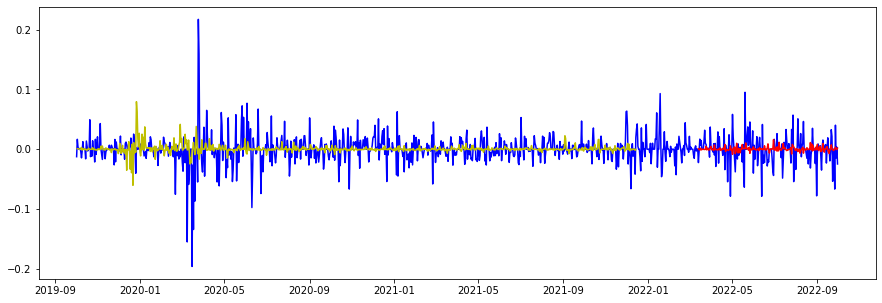

In [96]:
results=[]
incio=x_test[-1:].reshape(1, 1, x_test.shape[1])

parcial=model.predict(incio[0])
parcial_=scaler.inverse_transform(parcial.reshape(-1, 1))
results.append(parcial_[0][0])
incio=agregarNuevoValor(incio,parcial.reshape(-1, 1))
result=pd.DataFrame(results)[0]

plt.figure(figsize=(15,5))
plt.plot(idx.values,serie['variacion_log'],c='b', label='Serie Original')
plt.plot(idx_[len(x_train)+90:len(serie)].values,testPredict[0],c='r', label='Predicción Test')
plt.plot(idx_[1:len(x_train)+1].values,trainPredict[0],c='y', label='Predicción Train')
plt.plot(idx_[len(serie):len(idx_)].values,result,c='m', label='Predicción 90 Dias')
plt.xticks(rotation=90)
plt.legend(fontsize=10)
plt.title('Resultados del Modelo', fontsize=20)
#plt.title('Modelo XgBoost'+ " " + "Mean Absolute Error: {0:.2f}%".format(error) +' '+ 'Serie: ' +str(Accion), fontsize=20)
plt.xlabel('Días', fontsize=20)
plt.ylabel('Variacion Log precio Cierre', fontsize=20)
plt.show()


### Continuacion codigo

In [153]:
@interact_manual
def construccion_XGBoots(Guardar_Result=True,limpiar_result=False,Accion=data_series['nemotecnico'].unique(),Input_features=(1,90,1),dias_predecir=(1,90,1)):

    
    info = data_series[(data_series['nemotecnico']==Accion)]
    tabla=info.copy()
    serie = tabla[['fecha','nemotecnico','variacion_log']]
    del tabla, info
    #serie=data_series[(data_series['nemotecnico']==Accion)]
    serie.set_index('fecha',inplace=True)
    idx = pd.date_range(serie.index.min(), serie.index.max())
    idx_ = pd.date_range(serie.index.min(), serie.index.max()  + np.timedelta64(dias_predecir,'D'))
    serie=serie.reindex(idx, fill_value=0)
    serie.reset_index(inplace=True)
    serie.rename(columns={'index':'fecha'},inplace=True)
    serie.drop(columns=['nemotecnico'],inplace=True)
    serie.set_index('fecha',inplace=True)
    values = serie['variacion_log'].values
    values = values.astype('float32')
    
    Input_features=[5,15,30]
    param_nsteps=[]
    for i in Input_features:
        print('steps',i)

        scaler = MinMaxScaler(feature_range=(-1, 1))
        values=values.reshape(-1, 1) 
        scaled = scaler.fit_transform(values)
        reframed = serie_supervisada(scaled, i, 1)  
        train_size=len(reframed)*0.8
        print(len(reframed))
        print(reframed)
        print(train_size)
        values = reframed.values
        train,test  = values[:int(train_size), :],values[int(train_size):, :]
        x_train, y_train = train[:, :-1], train[:, -1]
        x_test, y_test = test[:, :-1], test[:, -1]
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1]))

    
        ###nuevo

        print('Tunning Hiperparametros Xgboost')

        hyperparameter_grid = {
        'n_estimators': [100, 500, 900, 1100, 1500],
        'max_depth': [2, 3, 5, 10, 15],
        'learning_rate': [0.05, 0.1, 0.15, 0.20],
        'min_child_weight': [1, 2, 3, 4]
        }


        regressor = XGBRegressor()

        random_cv = RandomizedSearchCV(estimator=regressor,
                param_distributions=hyperparameter_grid,
                cv=5, n_iter=50,
                scoring = 'neg_mean_absolute_error',n_jobs = 4,
                verbose = 5, 
                return_train_score = True,
                random_state=42)

        random_cv.fit(x_train,y_train)


        params=random_cv.best_params_

        print('Mejores Parametros: ' + str(Accion), params)


        model = xg.XGBRegressor(objective='reg:squarederror',**params,seed=1234)


    #     parameters = product(ps_, qs_, Ps_, Qs_)
    #     parameters_list = list(parameters)      


    # result_table = optimizerMODEL(serie,parameters_list, d_, D, s_,0,dias_predecir)
    # p, q, P, Q = result_table.parameters[0]
    # best_model = ARIMA(serie['variacion_log'], order=(p,d,q)).fit(disp=0)   


        ### hasta aqui

        #model = xg.XGBRegressor(objective='reg:squarederror', learning_rate=0.002, max_depth=10, n_estimators=1000)

        model.fit(x_train, y_train)
        testPredict=model.predict(x_test)           
        trainPredict = model.predict(x_train)
        testPredict=[a for a in testPredict]
        testPredict = scaler.inverse_transform(np.array(testPredict).reshape(1, -1))
        trainPredict=[a for a in trainPredict]
        trainPredict = scaler.inverse_transform(np.array(trainPredict).reshape(1, -1))
        y_train = scaler.inverse_transform([y_train])
        y_test = scaler.inverse_transform([y_test])

        error = mean_absolute_error(y_test[0], testPredict[0])
        print('mae:',error)
        error_rmse = rmse(y_test[0], testPredict[0])
        print('rmse:',error_rmse)
        error_mape = mean_absolute_percentage_error(y_test[0], testPredict[0])
        print('mape:',error_mape)
        
        results.append([parameters_list[j][0],parameters_list[j][1],
                        parameters_list[j][2],parameters_list[j][3],
                        parameters_list[j][4],MAE,RMSE,mape])

        
        

        results=[]
        incio=x_test[-1:].reshape(1, 1, x_test.shape[1])
        for i in range(dias_predecir):
            parcial=model.predict(incio[0])
            parcial_=scaler.inverse_transform(parcial.reshape(-1, 1))
            results.append(parcial_[0][0])
            incio=agregarNuevoValor(incio,parcial.reshape(-1, 1))
        result=pd.DataFrame(results)[0]



        plt.figure(figsize=(15,5))
        #plt.plot(idx.values,serie['variacion_log'],c='b', label='Serie Original')
        plt.plot(idx_[len(x_train)+Input_features:len(serie)].values,serie[len(x_train)+Input_features:len(serie)]['variacion_log'],c='b', label='Serie Original')
        plt.plot(idx_[len(x_train)+Input_features:len(serie)].values,testPredict[0],c='r', label='Predicción Test')
        #plt.plot(idx_[Input_features:len(x_train)+Input_features].values,trainPredict[0],c='y', label='Predicción Train')
        #plt.plot(idx_[len(serie):len(idx_)].values,result,c='m', label='Predicción 90 Dias')
        plt.xticks(rotation=90)
        plt.legend(fontsize=10)
        plt.title('Resultados del Modelo', fontsize=20)
        plt.title('Modelo XgBoost'+ " " + "Mean Absolute Error: {0:.2f}%".format(error) +' '+ 'Serie: ' +str(Accion), fontsize=20)
        plt.xlabel('Días', fontsize=20)
        plt.ylabel('Variacion Log precio Cierre', fontsize=20)
        plt.savefig(str(Accion) + '_xgb'+'.png')
        plt.show()

        dict_resul={'Serie':str(Accion),'Modelo':'XGBoots','MAE':error,'RMSE':error_rmse,'MAPE':error_mape,'PARAMETROS XGB':params}

        predicciones=pd.DataFrame(result)

        writer=pd.ExcelWriter('pronostico_xgb_' + str(Accion)+'.xlsx',engine='openpyxl')
        predicciones.to_excel(writer, sheet_name=f'{Accion}',index=False)
        writer.save()





        if Guardar_Result == True:    
            if limpiar_result == False:
                with open('C:/Users/USUARIO/Desktop/resultados_v1.json', 'a') as file:
                    file.write(json.dumps(dict_resul, ensure_ascii=False))
                    file.write("\n")
                    file.close()
            else:
                with open('C:/Users/USUARIO/Desktop/resultados_v1.json', 'w') as file:
                    file.write(json.dumps(dict_resul, ensure_ascii=False))
                    file.write("\n")
                    file.close()  
                
    
          
    
    #return reframed.head()
    return predicciones

interactive(children=(Checkbox(value=True, description='Guardar_Result'), Checkbox(value=False, description='l…

In [37]:
@interact_manual
def construccion_XGBoots(Guardar_Result=True,limpiar_result=False,Accion=data_series['nemotecnico'].unique(),Input_features=(1,90,1),dias_predecir=(1,90,1)):

    
    info = data_series[(data_series['nemotecnico']==Accion)]
    tabla=info.copy()
    serie = tabla[['fecha','nemotecnico','variacion_log']]
    del tabla, info
    #serie=data_series[(data_series['nemotecnico']==Accion)]
    serie.set_index('fecha',inplace=True)
    idx = pd.date_range(serie.index.min(), serie.index.max())
    idx_ = pd.date_range(serie.index.min(), serie.index.max()  + np.timedelta64(dias_predecir,'D'))
    serie=serie.reindex(idx, fill_value=0)
    serie.reset_index(inplace=True)
    serie.rename(columns={'index':'fecha'},inplace=True)
    serie.drop(columns=['nemotecnico'],inplace=True)
    serie.set_index('fecha',inplace=True)
    values = serie['variacion_log'].values
    values = values.astype('float32')
    

    scaler = MinMaxScaler(feature_range=(-1, 1))
    values=values.reshape(-1, 1) 
    scaled = scaler.fit_transform(values)
    reframed = serie_supervisada(scaled, Input_features, 1)  
    train_size=len(reframed)*0.8
    print(len(reframed))
    print(reframed)
    print(train_size)
    values = reframed.values
    train,test  = values[:int(train_size), :],values[int(train_size):, :]
    x_train, y_train = train[:, :-1], train[:, -1]
    x_test, y_test = test[:, :-1], test[:, -1]
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1]))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1]))

    
    ###nuevo

    print('Tunning Hiperparametros Xgboost')

    hyperparameter_grid = {
    'n_estimators': [100, 500, 900, 1100, 1500],
    'max_depth': [2, 3, 5, 10, 15],
    'learning_rate': [0.05, 0.1, 0.15, 0.20],
    'min_child_weight': [1, 2, 3, 4]
    }


    regressor = XGBRegressor()

    random_cv = RandomizedSearchCV(estimator=regressor,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,
            scoring = 'neg_mean_absolute_error',n_jobs = 4,
            verbose = 5, 
            return_train_score = True,
            random_state=42)

    random_cv.fit(x_train,y_train)


    params=random_cv.best_params_

    print('Mejores Parametros: ' + str(Accion), params)


    model = xg.XGBRegressor(objective='reg:squarederror',**params,seed=1234)

    model.fit(x_train, y_train)
    testPredict=model.predict(x_test)           
    trainPredict = model.predict(x_train)
    testPredict=[a for a in testPredict]
    testPredict = scaler.inverse_transform(np.array(testPredict).reshape(1, -1))
    trainPredict=[a for a in trainPredict]
    trainPredict = scaler.inverse_transform(np.array(trainPredict).reshape(1, -1))
    y_train = scaler.inverse_transform([y_train])
    y_test = scaler.inverse_transform([y_test])

    error = mean_absolute_error(y_test[0], testPredict[0])
    print('mae:',error)
    error_rmse = rmse(y_test[0], testPredict[0])
    print('rmse:',error_rmse)
    error_mape = mean_absolute_percentage_error(y_test[0], testPredict[0])
    print('mape:',error_mape)

    results=[]
    print(len(x_test))
    print(x_test)
    incio=x_test[-1:].reshape(1, 1, x_test.shape[1])
    print('impresion:',incio)
    for i in range(dias_predecir):
        print('otro:',incio[0])
        parcial=model.predict(incio[i])
        parcial_=scaler.inverse_transform(parcial.reshape(-1, 1))
        print(parcial_)
        results.append(parcial_[0][0])
        print(results)
        incio=agregarNuevoValor(incio,parcial.reshape(-1, 1))
    result=pd.DataFrame(results)[0]

    path_graficos='C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/graficos/'
    

    plt.figure(figsize=(7.28, 3.7))
    #plt.plot(idx.values,serie['variacion_log'],c='b', label='Serie Original')
    plt.plot(idx_[len(x_train)+Input_features:len(serie)].values,serie[len(x_train)+Input_features:len(serie)]['variacion_log'],color = '#000080', linewidth=2, alpha = 0.6, label='Serie Original')
    plt.plot(idx_[len(x_train)+Input_features:len(serie)].values,testPredict[0], label='Predicción Test',color = '#F0000F', linewidth=1)
    #plt.plot(idx_[Input_features:len(x_train)+Input_features].values,trainPredict[0],c='y', label='Predicción Train')
    #plt.plot(idx_[len(serie):len(idx_)].values,result,c='m', label='Predicción 90 Dias')
    plt.legend(['Test','Predicted'],loc=0, fontsize = 8)
    plt.xticks(rotation=90)
    plt.legend(fontsize=10)
    plt.title('Resultados del Modelo', fontsize=20)
    plt.title('Modelo XgBoost'+ " " + "Mean Absolute Error: {0:.2f}%".format(error) +' '+ 'Serie: ' +str(Accion), fontsize=20)
    plt.xlabel('Días', fontsize=20)
    plt.ylabel('Variacion Log precio Cierre', fontsize=20)
    plt.title(str(Accion), fontsize = 15)
    plt.savefig(path_graficos + str(Accion) + '_xgb'+'.jpg',facecolor='white')
    plt.show()
    
    

    dict_resul={'Serie':str(Accion),'Modelo':'XGBoots','MAE':error,'RMSE':error_rmse,'MAPE':error_mape,'PARAMETROS XGB':params}

    predicciones=pd.DataFrame(result)

#     writer=pd.ExcelWriter('pronostico_xgb_' + str(Accion)+'.xlsx',engine='openpyxl')
#     predicciones.to_excel(writer, sheet_name=f'{Accion}',index=False)
#     writer.save()


    if Guardar_Result == True:    
        if limpiar_result == False:
            with open('C:/Users/USUARIO/Desktop/resultados_v1.json', 'a') as file:
                file.write(json.dumps(dict_resul, ensure_ascii=False))
                file.write("\n")
                file.close()
        else:
            with open('C:/Users/USUARIO/Desktop/resultados_v1.json', 'w') as file:
                file.write(json.dumps(dict_resul, ensure_ascii=False))
                file.write("\n")
                file.close()  
                
    
          
    
    #return reframed.head()
    return predicciones

interactive(children=(Checkbox(value=True, description='Guardar_Result'), Checkbox(value=False, description='l…

# Series multivariadas con redes neuronales

Es este caso se construirá un modelo de predicción que tendrá como inputs las series temporales de las terminales y tipos de operación elegidos. Estos nos ayudaran para predecir el total de transacciones (suma de estas series temporales), para los próximos 15 días.

In [26]:
def series_seq(x,y, n_steps):
    X_, y_ = list(), list()
    for i in range(len(x)):
        end_ix = i + n_steps
        if end_ix > len(x):
             break
        seq_x, seq_y = x[i:end_ix], y[end_ix-1]
        X_.append(seq_x)
        y_.append(seq_y)
    return np.array(X_), np.array(y_)

In [27]:
data_series.head()

,Unnamed: 0,nemotecnico,fecha,cantidad,volumen,precio_cierre,precio_mayor,precio_medio,precio_menor,variacion%,variacion_log,dia_semana
0,0,BCOLOMBIA,2019-10-02,284830.0,1.126933e+10,39500.0,39980.0,39565.11,39500.0,-1.25,-0.012579,Wednesday
1,1,BCOLOMBIA,2019-10-03,140793.0,5.645285e+09,40160.0,40200.0,40096.35,39060.0,1.67,0.016571,Thursday
2,2,BCOLOMBIA,2019-10-04,24249.0,9.755599e+08,40300.0,40300.0,40230.93,39880.0,0.35,0.003480,Friday
3,3,BCOLOMBIA,2019-10-07,573422.0,2.294618e+10,40360.0,40400.0,40016.22,40000.0,0.15,0.001488,Monday
4,4,BCOLOMBIA,2019-10-08,97905.0,3.917192e+09,40200.0,40200.0,40010.14,39540.0,-0.40,-0.003972,Tuesday


In [28]:
tabla_multi=data_series.groupby(['fecha','nemotecnico']).agg({'variacion_log':'mean'})
tabla_multi=tabla_multi.unstack().fillna(0)
#tabla_multi=tabla_multi.unstack(1).fillna(0)
tabla_multi=tabla_multi.stack()
#tabla_multi=tabla_multi.stack()
tabla_multi

variacion_log
fecha      nemotecnico               
2019-10-02 BCOLOMBIA        -0.012579
           BOGOTA            0.005982
           BVC              -0.008734
           CELSIA           -0.013793
           CEMARGOS          0.028632
...                               ...
2022-09-30 PFCEMARGOS        0.000000
           PFCORFICOL       -0.036368
           PFDAVVNDA         0.004344
           PFGRUPOARG        0.000000
           PFGRUPSURA        0.012579

[15393 rows x 1 columns]

# 5. Resultados

In [150]:
with open('C:/Users/USUARIO/Desktop/resultados_v1.json') as json_file:
    data=json_file.readlines()
    data=[a.replace('\n','') for a in data]
    mae=[json.loads(a)['MAE'] for a in data]
    mape=[json.loads(a)['MAPE'] for a in data]
    rmse=[json.loads(a)['RMSE'] for a in data]
    params=[json.loads(a)['PARAMETROS XGB'] for a in data]
    serie=[json.loads(a)['Serie'] for a in data]
    modelo=[json.loads(a)['Modelo'] for a in data]
    info=pd.DataFrame (columns = ['Serie','Modelo','RMSE','MAE','MAPE','PARAMETROS'])
    info['Serie']=serie
    info['Modelo']=modelo
    info['RMSE']=rmse
    info['MAE']=mae
    info['MAPE']=mape
    info['PARAMETROS']=params
    info.set_index('PARAMETROS',inplace=True)
    tabla=info.groupby(['Serie','Modelo']).agg({'MAE':'min','RMSE':'min', 'MAPE':'min'}).sort_values(by=['Serie','Modelo'])
    tabla.head(25)

In [151]:
data

['{"Serie": "CEMARGOS", "Modelo": "XGBoots", "MAE": 0.014334703752696912, "RMSE": 0.023538958556806884, "MAPE": 104.80273517017595, "PARAMETROS XGB": {"n_estimators": 100, "min_child_weight": 1, "max_depth": 2, "learning_rate": 0.05}}']

In [100]:
info.reset_index(inplace=True)

In [107]:
info.columns

Index(['Serie', 'Modelo', 'RMSE', 'MAE', 'MAPE'], dtype='object')

In [108]:
info.sort_values(by=[
                     'Serie',
                     'Modelo','MAE'],ascending=True, inplace=True)
print(info.shape)
info.drop_duplicates([
            'Serie',
            'Modelo'],keep='first', inplace=True)
print(info.shape)

(42, 5)
(42, 5)


In [110]:
info.reset_index(inplace=True)
info

,PARAMETROS,Serie,Modelo,RMSE,MAE,MAPE
0,"{'epochs': 500, 'batch_size': 15, 'validation_...",BCOLOMBIA,Red Neuronal,0.022515,0.013789,78.116162
1,"{'n_estimators': 100, 'min_child_weight': 1, '...",BCOLOMBIA,XGBoots,0.022584,0.013970,102.099959
2,"{'epochs': 500, 'batch_size': 15, 'validation_...",BOGOTA,Red Neuronal,0.028875,0.014758,135.218392
3,"{'n_estimators': 100, 'min_child_weight': 1, '...",BOGOTA,XGBoots,0.029908,0.014334,89.346204
4,"{'epochs': 500, 'batch_size': 15, 'validation_...",BVC,Red Neuronal,0.015222,0.007794,59.423034
5,"{'n_estimators': 100, 'min_child_weight': 1, '...",BVC,XGBoots,0.015427,0.008335,102.381716
6,"{'epochs': 500, 'batch_size': 15, 'validation_...",CELSIA,Red Neuronal,0.013856,0.007918,76.909518
7,"{'n_estimators': 100, 'min_child_weight': 1, '...",CELSIA,XGBoots,0.014248,0.008302,102.662096
8,"{'epochs': 500, 'batch_size': 15, 'validation_...",CEMARGOS,Red Neuronal,0.022787,0.013610,70.495680
9,"{'n_estimators': 100, 'min_child_weight': 1, '...",CEMARGOS,XGBoots,0.023155,0.014086,92.534752


In [111]:
with pd.ExcelWriter('resultados_modelos_tesis.xlsx',engine='xlsxwriter') as writer:
    info.to_excel(writer, sheet_name='resultados')
    writer.save()

In [89]:
 tabla.reset_index()

,Serie,Modelo,MAE,RMSE,MAPE
0,BCOLOMBIA,Red Neuronal,0.013789,0.022515,78.116162
1,BCOLOMBIA,XGBoots,0.013970,0.022584,102.099959


### Leyendo los pronosticos para concatenarlos

In [132]:
import os
os.getcwd()

'C:\\Users\\USUARIO\\Downloads\\lstm_with_pytorch_and_lightning_v1.0\\lstm_with_pytorch_and_lightning'

In [148]:
path = "C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/pronosticos"
dir_list = os.listdir(path)

print("Archivos y Carpetas en'", path, "' :")
print('\n')
print(dir_list)


Archivos y Carpetas en' C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/pronosticos ' :


['consolidado_pronosticos_xgb.xlsx', 'pronostico_xgb_BCOLOMBIA.xlsx', 'pronostico_xgb_BOGOTA.xlsx', 'pronostico_xgb_BVC.xlsx', 'pronostico_xgb_CELSIA.xlsx', 'pronostico_xgb_CEMARGOS.xlsx']


In [134]:
dir_list=[x for x in dir_list if 'pronostico_xgb' in x]
print('catidad de archivos asociados a las acciones fueron cargados:',len(dir_list))
dir_list

catidad de archivos asociados a las acciones fueron cargados: 5


['pronostico_xgb_BCOLOMBIA.xlsx',
 'pronostico_xgb_BOGOTA.xlsx',
 'pronostico_xgb_BVC.xlsx',
 'pronostico_xgb_CELSIA.xlsx',
 'pronostico_xgb_CEMARGOS.xlsx']

In [140]:
str('pronostico_xgb_BCOLOMBIA.xlsx')[15:-5]

'BCOLOMBIA'

In [141]:
str('pronostico_xgb_BOGOTA.xlsx')[15:-5]

'BOGOTA'

In [145]:
df_list=[]

for i in dir_list:
    temp_df = pd.read_excel(path + '/' + i)
    print(str(i)[15:-5])
    temp_df['nemotecnico']=str(i)[15:-5]
    temp_df.rename(columns={0:'pronostico'},inplace=True)
    temp_df=temp_df[['nemotecnico','pronostico']]
    print('Tamaño Base:',temp_df.shape)
    print('\n')
    df_list.append(temp_df)
    
df_final = pd.concat(df_list)
print('Tamaño Base unida:', df_final.shape)
df_final.head()

BCOLOMBIA
Tamaño Base: (90, 2)


BOGOTA
Tamaño Base: (90, 2)


BVC
Tamaño Base: (90, 2)


CELSIA
Tamaño Base: (90, 2)


CEMARGOS
Tamaño Base: (90, 2)


Tamaño Base unida: (450, 2)


,nemotecnico,pronostico
0,BCOLOMBIA,-0.002547
1,BCOLOMBIA,-0.005992
2,BCOLOMBIA,0.000695
3,BCOLOMBIA,-0.000037
4,BCOLOMBIA,0.000228


In [146]:
path

'C:/Users/USUARIO/Downloads/lstm_with_pytorch_and_lightning_v1.0/lstm_with_pytorch_and_lightning/pronosticos'

In [149]:
df_final.to_excel(path + '/consolidado_pronosticos_xgb.xlsx',index=False)

In [143]:
df_final.columns

Index([0, 'nemotecnico'], dtype='object')